In [20]:
import numpy as np
import cv2 as cv
import glob
import flowiz as fz
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import linalg as LA

In [21]:
flos_path = glob.glob('./img/TUM/*.flo')
flos_path

['./img/TUM/36.flo', './img/TUM/37.flo', './img/TUM/38.flo']

In [22]:
images_path = glob.glob('./img/TUM/*.png')
images_path

['./img/TUM/36.png', './img/TUM/38.png', './img/TUM/37.png']

In [81]:
flow1 = fz.read_flow(path='./img/TUM/37.flo')
flow2 = fz.read_flow(path='./img/TUM/38.flo')
print(flow1.shape)
print(flow1.dtype)

(480, 640, 2)
float32


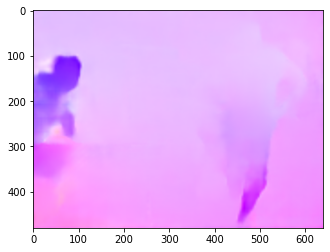

In [82]:
plt_f1 = fz.convert_from_flow(flow1)
plt_f2 = fz.convert_from_flow(flow2)
plt.imshow(plt_f1)

2.914858 -3.9422107
4.902797


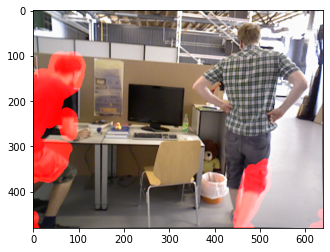

In [152]:
mask_dynamic = np.zeros(image0_rgb.shape, np.uint8)
mean1 = np.mean(flow1[:,:,0])
mean2 = np.mean(flow1[:,:, 1])
print(mean1, mean2)
avg_norm = LA.norm([mean1, mean2])
print(avg_norm)
for y in range(flow1.shape[0]):
    for x in range(flow1.shape[1]):
        f = flow1[y, x]
        mg = LA.norm(f)
        if mg > avg_norm*3/2.0:
#         if mg > 6:
            cv.circle(mask_dynamic,(x,y), 10 , (255, 0, 0),-1)

show_dynamic = cv.add(mask_dynamic, image0_rgb)            
plt.imshow(show_dynamic)

(480, 640, 3)


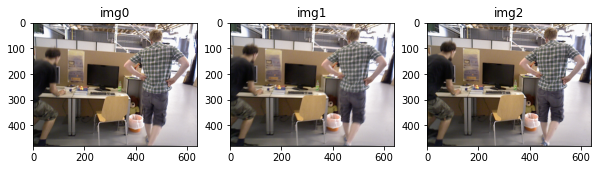

In [83]:
image0_bgr = cv.imread('./img/TUM/36.png')
image1_bgr = cv.imread('./img/TUM/37.png')
image2_bgr = cv.imread('./img/TUM/38.png')
image0_rgb = cv.cvtColor(image0_bgr, cv.COLOR_BGR2RGB)
image1_rgb = cv.cvtColor(image1_bgr, cv.COLOR_BGR2RGB)
image2_rgb = cv.cvtColor(image2_bgr, cv.COLOR_BGR2RGB)
fig_image, axarr_image = plt.subplots(1,3)
fig_image.set_size_inches(10, 5)
axarr_image[0].set_title('img0')
axarr_image[0].imshow(image0_rgb)
axarr_image[1].set_title('img1')
axarr_image[1].imshow(image1_rgb)
axarr_image[2].set_title('img2')
axarr_image[2].imshow(image2_rgb)
print(image1_rgb.shape)

In [109]:
# Extract feature point
image0_gray = cv.cvtColor(image0_bgr, cv.COLOR_BGR2GRAY)
image1_gray = cv.cvtColor(image1_bgr, cv.COLOR_BGR2GRAY)
print(image1_gray.shape)

# Extract features
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
image0_features= cv.goodFeaturesToTrack(image0_gray, mask = None, **feature_params)
print(image0_features.shape)

image1_features= cv.goodFeaturesToTrack(image1_gray, mask = None, **feature_params)

# # Parameters for lucas kanade optical flow
# lk_params = dict( winSize  = (15,15),
#                   maxLevel = 2,
#                   criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
# # calculate optical flow
# image1_features, status, error = cv.calcOpticalFlowPyrLK(image0_gray, image1_gray, image1_features, None, **lk_params)

(480, 640)
(66, 1, 2)


In [124]:
# Show optical flow direction
mask0 = np.zeros_like(image0_rgb)
mask1 = np.zeros_like(image1_rgb)
mask2 = np.zeros_like(image1_rgb)
mask1_gt = np.zeros_like(image1_rgb)

for i in range(image0_features.shape[0]):
    x = int(image0_features[i, 0, 0])
    y = int(image0_features[i, 0, 1])
    # show features detected on img0
    cv.circle(mask0,(x,y), 10 , (0, 255, 255),-1)
    
    # predict features on image 1
    fl1 = flow1[y, x]
    x1 = int(x + fl1[1])
    y1 = int(y + fl1[0])
    
    if x1 < 0 or x1 > mask1.shape[1] or y1 < 0 or y1 > mask1.shape[0]:
        continue
    cv.circle(mask1,(x,y), 10 , (0, 255, 0),-1)
    cv.circle(mask1,(x1,y1), 10 , (255, 0, 0),-1)
    cv.line(mask1, (x, y), (x1, y1), (255, 255, 0), 5) 
   
    # predict features on image 2
    fl2 = flow2[y1, x1]
    x2 = int(x1 + fl2[1])
    y2 = int(y1 + fl2[0])
    if x2 < 0 or x2 > mask2.shape[1] or y2 < 0 or y2 > mask2.shape[0]:
        continue
    cv.circle(mask2,(x2, y2), 10 , (255, 0, 0),-1)
    cv.line(mask2, (x1, y1), (x2, y2), (255, 255, 0), 5) 

# show ground truth (so called)
for i in range(image1_features.shape[0]):
    x = int(image1_features[i, 0, 0])
    y = int(image1_features[i, 0, 1])
    # show features detected on img0
    cv.circle(mask1_gt,(x,y), 10 , (255, 0, 255),-1)


show_mask0 = cv.add(image0_rgb, mask0)
show_mask1 = cv.add(image1_rgb, mask1)
show_mask2 = cv.add(image2_rgb, mask2)
show_mask1_gt = cv.add(image1_rgb, mask1_gt)


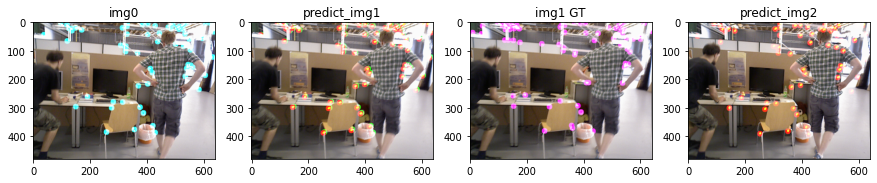

In [125]:
fig_result, axarr_result = plt.subplots(1, 4)
fig_result.set_size_inches(15, 5)
axarr_result[0].set_title('img0')
axarr_result[0].imshow(show_mask0)
axarr_result[1].set_title('predict_img1')
axarr_result[1].imshow(show_mask1)
axarr_result[2].set_title('img1 GT')
axarr_result[2].imshow(show_mask1_gt)
axarr_result[3].set_title('predict_img2')
axarr_result[3].imshow(show_mask2)